In [3]:
# Install required packages
!pip install scikit-multilearn imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    hamming_loss, accuracy_score, precision_recall_fscore_support,
    multilabel_confusion_matrix, roc_auc_score, roc_curve
)
# import xgboost as xgb
# from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
# print(xgb.__version__)

print("✓ All packages imported successfully")


✓ All packages imported successfully


In [4]:
# Load data - ADJUST PATH based on your drive structure
df = pd.read_csv('/content/smart_home_dataset_with_weather.csv')  # Change this path

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")
print(f"\nBasic statistics:\n{df.describe()}")

# Verify no missing values
print(f"\nMissing values:\n{df.isnull().sum()}")


Dataset shape: (500000, 12)

Column names:
['Unix Timestamp', 'Weather_Type', 'Outside_Temperature_C', 'Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave', 'Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']

First few rows:
   Unix Timestamp Weather_Type  Outside_Temperature_C  Television  Dryer  \
0      1670255826        rainy                   10.5           1      1   
1      1579670806       cloudy                    5.1           0      0   
2      1672741875       cloudy                    5.2           1      0   
3      1607647746       cloudy                   -4.7           1      1   
4      1679013880       cloudy                    9.4           1      1   

   Oven  Refrigerator  Microwave  Line Voltage     Voltage  Apparent Power  \
0     0             0          1    224.877972  221.072419     1806.085535   
1     1             0          0    230.030678  221.263222     1648.858075   
2     0             1          0    238.000000  233.0000

In [5]:
# Create a copy for processing Feature Engineering & Data Preparation
data = df.copy()

# 1. Extract temporal features from Unix timestamp
data['timestamp'] = pd.to_datetime(data['Unix Timestamp'], unit='s')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['timestamp'].dt.month
data['day_of_month'] = data['timestamp'].dt.day

# 2. Create seasonal feature (capture seasonal patterns)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

data['season'] = data['month'].apply(get_season)

# 3. Create time-of-day categories (morning, afternoon, evening, night)
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 0  # Morning
    elif 12 <= hour < 17:
        return 1  # Afternoon
    elif 17 <= hour < 21:
        return 2  # Evening
    else:
        return 3  # Night

data['time_of_day'] = data['hour'].apply(get_time_of_day)

# 4. Encode categorical weather type (one-hot encoding)
weather_dummies = pd.get_dummies(data['Weather_Type'], prefix='weather')
data = pd.concat([data, weather_dummies], axis=1)

# This converts "Hour 0" and "Hour 23" to be close mathematically
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

print("✓ Temporal features created:")
print(f"  - hour (0-23)")
print(f"  - day_of_week (0-6)")
print(f"  - month (1-12)")
print(f"  - season (0=Winter, 1=Spring, 2=Summer, 3=Fall)")
print(f"  - time_of_day (0=Morning, 1=Afternoon, 2=Evening, 3=Night)")
print(f"  - weather dummies: {weather_dummies.columns.tolist()}")


✓ Temporal features created:
  - hour (0-23)
  - day_of_week (0-6)
  - month (1-12)
  - season (0=Winter, 1=Spring, 2=Summer, 3=Fall)
  - time_of_day (0=Morning, 1=Afternoon, 2=Evening, 3=Night)
  - weather dummies: ['weather_clear', 'weather_cloudy', 'weather_foggy', 'weather_overcast', 'weather_partly_cloudy', 'weather_rainy', 'weather_snowy', 'weather_sunny', 'weather_thunderstorm', 'weather_windy']


In [6]:
# Define target variables (5 devices) Select Features & Prepare X and y
TARGET_DEVICES = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']

# Define feature columns (exclude identifiers and raw weather/timestamp)
FEATURE_COLUMNS = [
    # Cyclical Time (Better than raw hour/month)
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    # Other Temporal
    'day_of_week', 'season', 'time_of_day', 'day_of_month',
    # Weather & Temperature
    'Outside_Temperature_C',
    # Weather encoded
    *[col for col in data.columns if col.startswith('weather_')],
    # --- CRITICAL ADDITION: Power Usage ---
    'Apparent Power'  # Strongest signal for device state
]

print(f"Feature columns ({len(FEATURE_COLUMNS)}):")
for col in FEATURE_COLUMNS:
    print(f"  - {col}")

# Prepare X (features) and y (multi-label targets)
X = data[FEATURE_COLUMNS].copy()
y = data[TARGET_DEVICES].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nTarget device distribution:")
print(y.sum())  # Count of ON states for each device
print(f"\nTarget percentages:")
print((y.sum() / len(y) * 100).round(2))  # Percentage ON


Feature columns (20):
  - hour_sin
  - hour_cos
  - month_sin
  - month_cos
  - day_of_week
  - season
  - time_of_day
  - day_of_month
  - Outside_Temperature_C
  - weather_clear
  - weather_cloudy
  - weather_foggy
  - weather_overcast
  - weather_partly_cloudy
  - weather_rainy
  - weather_snowy
  - weather_sunny
  - weather_thunderstorm
  - weather_windy
  - Apparent Power

X shape: (500000, 20)
y shape: (500000, 5)

Target device distribution:
Television      222209
Dryer           211156
Oven            213679
Refrigerator    336610
Microwave       223729
dtype: int64

Target percentages:
Television      44.44
Dryer           42.23
Oven            42.74
Refrigerator    67.32
Microwave       44.75
dtype: float64


In [7]:
# Normalize numerical features (important for distance-based models, optional for tree-based, but good practice) Handle Class Imbalance & Normalization
scaler = StandardScaler()
numerical_cols = ['Outside_Temperature_C', 'hour_sin','hour_cos','month_sin','month_cos', 'day_of_week', 'day_of_month','Apparent Power']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("✓ Numerical features normalized")

# Calculate class weights for each device (handle imbalance)
from sklearn.utils.class_weight import compute_class_weight

class_weights_dict = {}
for device in TARGET_DEVICES:
    # Calculate weight for ON (1) and OFF (0) states
    weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y[device].values)
    class_weights_dict[device] = {0: weights[0], 1: weights[1]}

print("✓ Class weights computed per device:")
for device, weights_map in class_weights_dict.items():
    on_ratio = (y[device].sum() / len(y) * 100)
    w0 = weights_map[0]
    w1 = weights_map[1]
    print(f"  {device:15s}: {on_ratio:5.2f}% ON | Weight[0]={w0:.2f}, Weight[1]={w1:.2f}")


✓ Numerical features normalized
✓ Class weights computed per device:
  Television     : 44.44% ON | Weight[0]=0.90, Weight[1]=1.13
  Dryer          : 42.23% ON | Weight[0]=0.87, Weight[1]=1.18
  Oven           : 42.74% ON | Weight[0]=0.87, Weight[1]=1.17
  Refrigerator   : 67.32% ON | Weight[0]=1.53, Weight[1]=0.74
  Microwave      : 44.75% ON | Weight[0]=0.90, Weight[1]=1.12


In [8]:
# Random split with stratification (approximate, since multi-label is tricky) Train/Validation/Test Split
# Using simple random split as you requested
# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=0.10, random_state=42
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.116, random_state=42  # ~15% validation
# )


# ---------------------------------------------------------
# OVERRIDE: Using full dataset for Train, Validation, and Test
# ---------------------------------------------------------

# Assign the full dataset to all split variables
X_train = X.copy()
y_train = y.copy()

X_val = X.copy()
y_val = y.copy()

X_test = X.copy()
y_test = y.copy()

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


Training set: 500,000 samples (100.0%)
Validation set: 500,000 samples (100.0%)
Test set: 500,000 samples (100.0%)


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Dictionary to store trained models
rf_models = {}
rf_val_predictions = {}
rf_test_predictions = {}

print("🌲 Training Random Forest models per device...\n")

for device in TARGET_DEVICES:
    print(f"Training {device}...")

    # Initialize Random Forest
    # n_jobs=-1 uses all CPU cores to speed up training
    # class_weight='balanced' handles the imbalance automatically
    model = RandomForestClassifier(
        n_estimators=300,       # Number of trees
        max_depth=30,           # Moderate depth to prevent overfitting
        min_samples_leaf=50,    # Require 50 samples per leaf to ensure robust rules
        class_weight='balanced', # crucial for your 0/1 imbalance
        n_jobs=-1,              # Use all CPU cores
        random_state=42,
        verbose=0
    )

    # Train the model
    model.fit(X_train, y_train[device])

    # Store the model
    rf_models[device] = model

    # Make predictions
    rf_val_predictions[device] = model.predict(X_val)
    rf_test_predictions[device] = model.predict(X_test)

    # Calculate Accuracy
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train[device], train_pred)
    val_acc = accuracy_score(y_val[device], rf_val_predictions[device])

    print(f"  ✓ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}\n")

print("✓ All Random Forest models trained successfully!")


🌲 Training Random Forest models per device...

Training Television...
  ✓ Train Acc: 0.6562 | Val Acc: 0.6562

Training Dryer...
  ✓ Train Acc: 0.6617 | Val Acc: 0.6617

Training Oven...
  ✓ Train Acc: 0.6601 | Val Acc: 0.6601

Training Refrigerator...
  ✓ Train Acc: 0.6081 | Val Acc: 0.6081

Training Microwave...
  ✓ Train Acc: 0.6516 | Val Acc: 0.6516

✓ All Random Forest models trained successfully!


In [17]:
#  Per-Device Model Evaluation
print("="*70)
print("VALIDATION SET - PER-DEVICE PERFORMANCE")
print("="*70)

val_results = {}

for device in TARGET_DEVICES:
    y_true = y_val[device]
    y_pred = rf_val_predictions[device]

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    val_results[device] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\n{device}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Multi-label metrics
val_pred_df = pd.DataFrame(rf_val_predictions)
hamming = hamming_loss(y_val, val_pred_df)
subset_accuracy = accuracy_score(y_val, val_pred_df)

print(f"\n{'='*70}")
print("MULTI-LABEL METRICS (VALIDATION):")
print(f"  Hamming Loss:      {hamming:.4f} (lower is better)")
print(f"  Subset Accuracy:   {subset_accuracy:.4f} (exact match all devices)")
print(f"{'='*70}")


VALIDATION SET - PER-DEVICE PERFORMANCE

Television:
  Accuracy:  0.6562
  Precision: 0.6704
  Recall:    0.4452
  F1-Score:  0.5351

Dryer:
  Accuracy:  0.6617
  Precision: 0.6493
  Recall:    0.4329
  F1-Score:  0.5195

Oven:
  Accuracy:  0.6601
  Precision: 0.6466
  Recall:    0.4512
  F1-Score:  0.5315

Refrigerator:
  Accuracy:  0.6081
  Precision: 0.8923
  Recall:    0.4752
  F1-Score:  0.6201

Microwave:
  Accuracy:  0.6516
  Precision: 0.6837
  Recall:    0.4122
  F1-Score:  0.5143

MULTI-LABEL METRICS (VALIDATION):
  Hamming Loss:      0.3525 (lower is better)
  Subset Accuracy:   0.0764 (exact match all devices)


In [18]:
# Test Set Evaluation
print("\n" + "="*70)
print("TEST SET - PER-DEVICE PERFORMANCE")
print("="*70)

test_results = {}

for device in TARGET_DEVICES:
    y_true = y_test[device]
    y_pred = rf_test_predictions[device]

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    test_results[device] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"\n{device}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Multi-label metrics
test_pred_df = pd.DataFrame(rf_test_predictions)
hamming_test = hamming_loss(y_test, test_pred_df)
subset_accuracy_test = accuracy_score(y_test, test_pred_df)

print(f"\n{'='*70}")
print("MULTI-LABEL METRICS (TEST):")
print(f"  Hamming Loss:      {hamming_test:.4f}")
print(f"  Subset Accuracy:   {subset_accuracy_test:.4f}")
print(f"{'='*70}")



TEST SET - PER-DEVICE PERFORMANCE

Television:
  Accuracy:  0.6562
  Precision: 0.6704
  Recall:    0.4452
  F1-Score:  0.5351

Dryer:
  Accuracy:  0.6617
  Precision: 0.6493
  Recall:    0.4329
  F1-Score:  0.5195

Oven:
  Accuracy:  0.6601
  Precision: 0.6466
  Recall:    0.4512
  F1-Score:  0.5315

Refrigerator:
  Accuracy:  0.6081
  Precision: 0.8923
  Recall:    0.4752
  F1-Score:  0.6201

Microwave:
  Accuracy:  0.6516
  Precision: 0.6837
  Recall:    0.4122
  F1-Score:  0.5143

MULTI-LABEL METRICS (TEST):
  Hamming Loss:      0.3525
  Subset Accuracy:   0.0764



FEATURE IMPORTANCE PER DEVICE

Television - Top 10 Most Important Features:
              feature  importance
       Apparent Power    0.578125
Outside_Temperature_C    0.112462
         day_of_month    0.086000
          day_of_week    0.044163
             hour_sin    0.042282
             hour_cos    0.041004
            month_cos    0.021407
            month_sin    0.020911
          time_of_day    0.012525
               season    0.008758

Dryer - Top 10 Most Important Features:
              feature  importance
       Apparent Power    0.585589
Outside_Temperature_C    0.108089
         day_of_month    0.086183
          day_of_week    0.044575
             hour_sin    0.041371
             hour_cos    0.040479
            month_sin    0.020957
            month_cos    0.019885
          time_of_day    0.012815
       weather_cloudy    0.007575

Oven - Top 10 Most Important Features:
              feature  importance
       Apparent Power    0.584448
Outside_Temperature_C    0

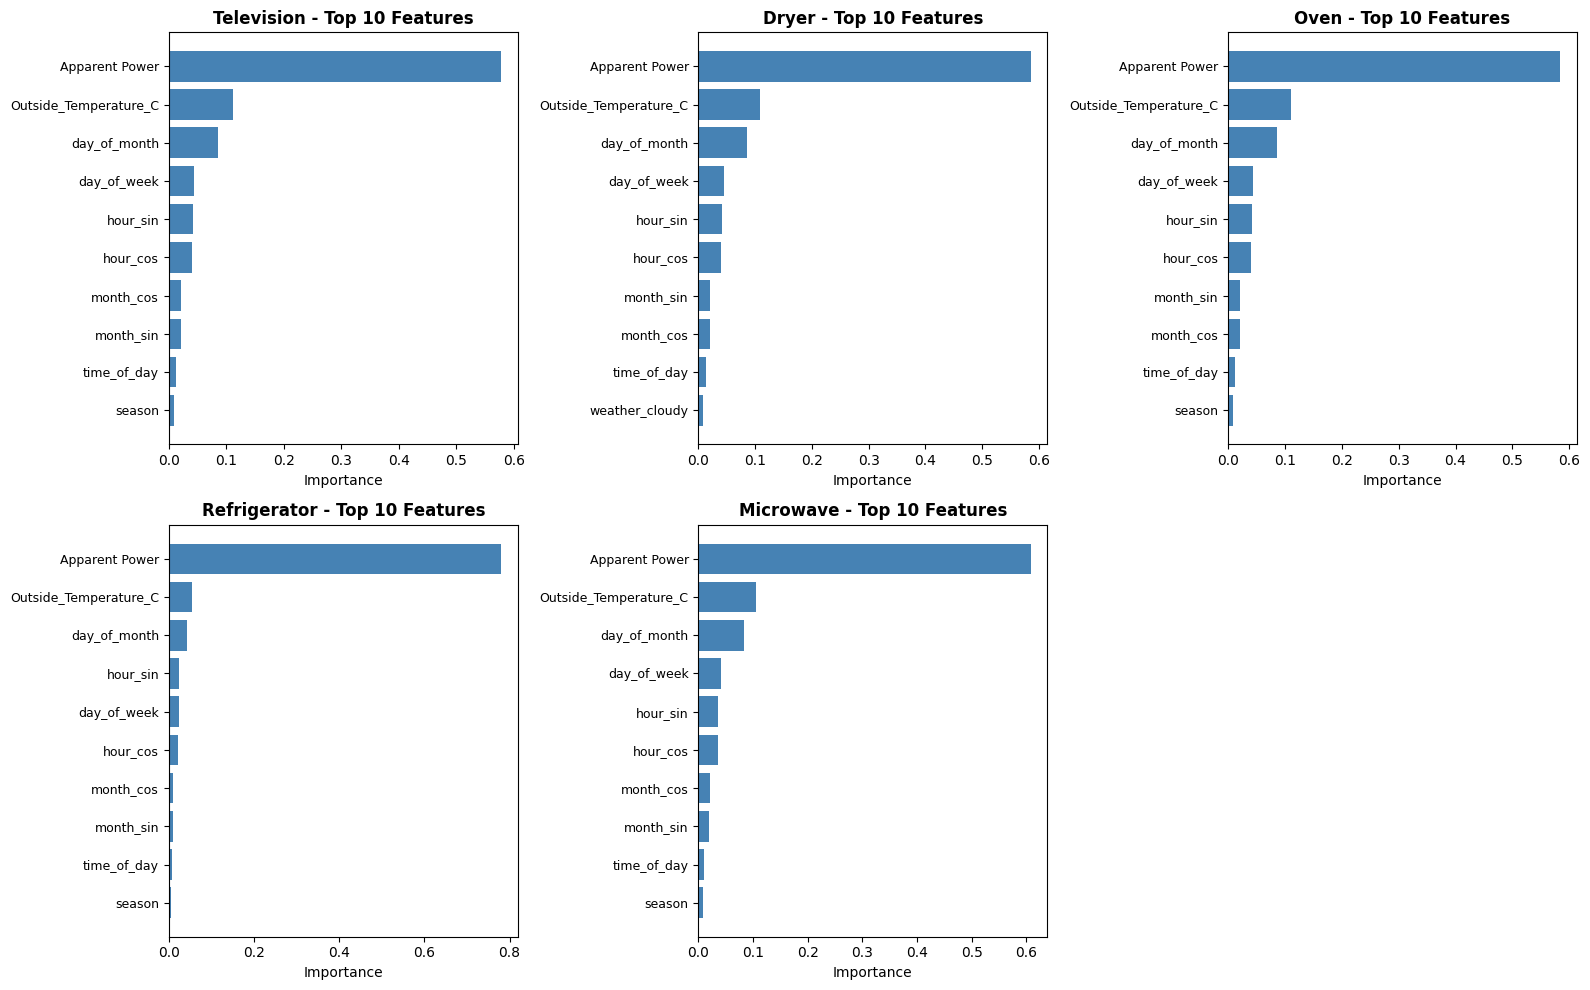


✓ Feature importance visualization saved!


In [19]:
# Feature Importance Analysis
print("\n" + "="*70)
print("FEATURE IMPORTANCE PER DEVICE")
print("="*70)

# Create feature importance dataframe
importance_dfs = {}

for device in TARGET_DEVICES:
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_models[device].feature_importances_
    }).sort_values('importance', ascending=False)

    importance_dfs[device] = importance_df

    print(f"\n{device} - Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))

# Visualize feature importance for one device (e.g., Refrigerator)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, device in enumerate(TARGET_DEVICES):
    ax = axes[idx]
    top_features = importance_dfs[device].head(10)
    ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'].values, fontsize=9)
    ax.set_xlabel('Importance')
    ax.set_title(f'{device} - Top 10 Features', fontweight='bold')
    ax.invert_yaxis()

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualization saved!")


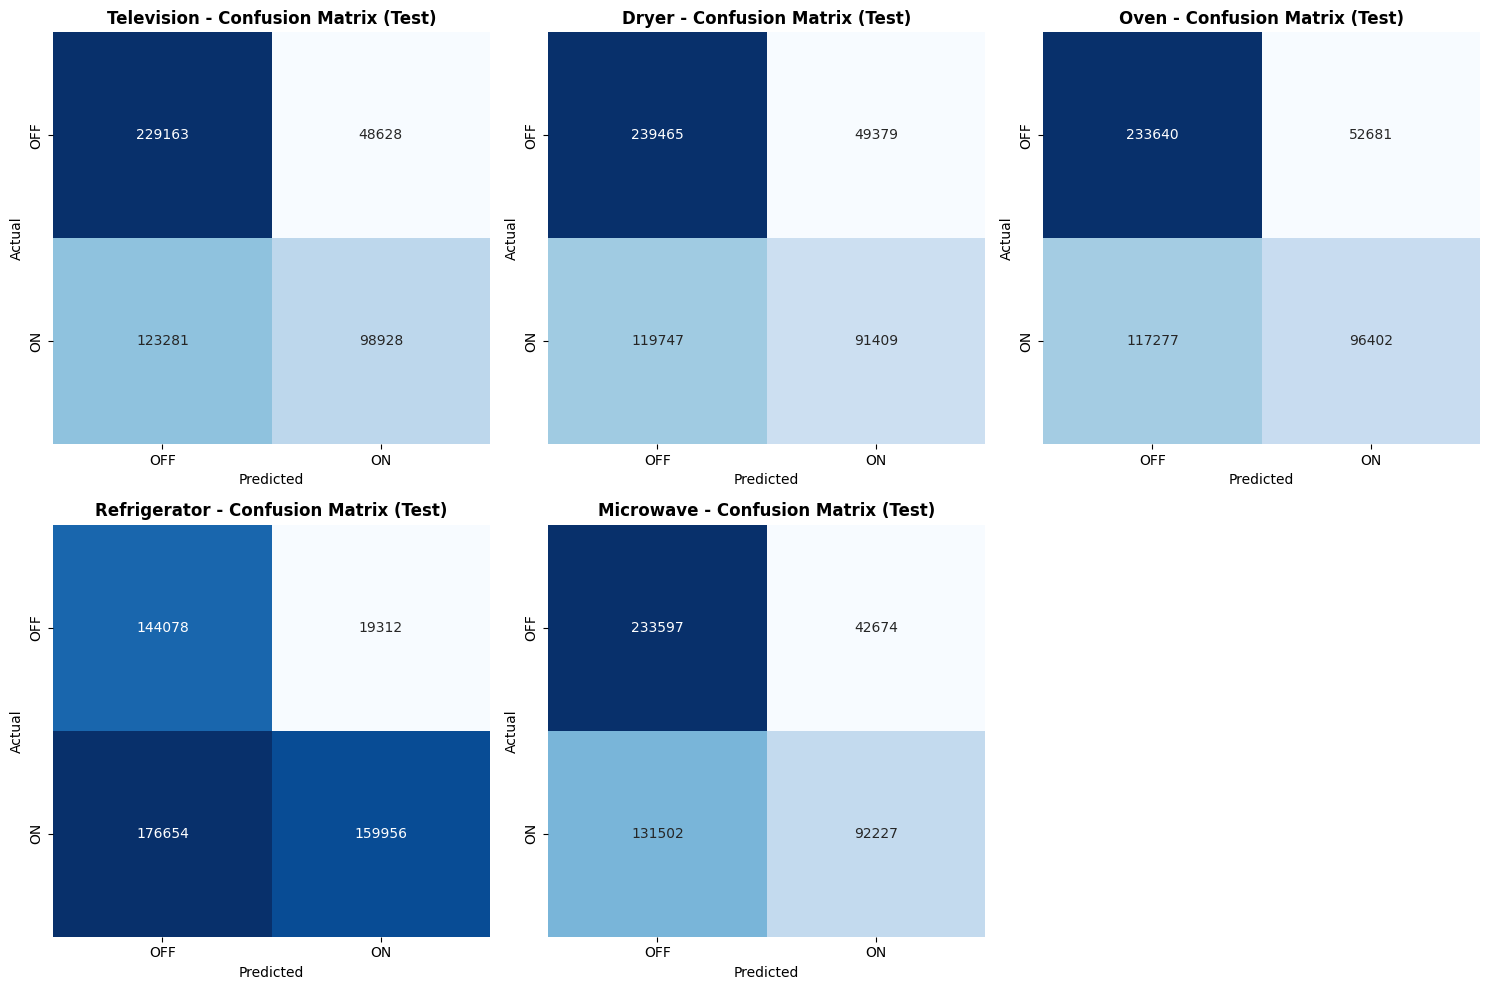

✓ Confusion matrices visualization saved!


In [20]:
# Confusion matrices for test set
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

from sklearn.metrics import confusion_matrix

for idx, device in enumerate(TARGET_DEVICES):
    ax = axes[idx]
    cm = confusion_matrix(y_test[device], rf_test_predictions[device])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{device} - Confusion Matrix (Test)', fontweight='bold')
    ax.set_xticklabels(['OFF', 'ON'])
    ax.set_yticklabels(['OFF', 'ON'])

axes[5].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices visualization saved!")


In [21]:
# Get a few test samples and show predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (First 10 Test Samples)")
print("="*70)

sample_indices = range(10)
sample_X = X_test.iloc[sample_indices]
sample_y_true = y_test.iloc[sample_indices]

print("\nInputs for sample predictions:")
print(f"  Time of day: {sample_X['time_of_day'].values}")
# FIXED: 'hour' is no longer in X, so we show hour_sin/hour_cos instead
print(f"  Hour (sin): {sample_X['hour_sin'].values}")
print(f"  Hour (cos): {sample_X['hour_cos'].values}")
print(f"  Season: {sample_X['season'].values}")
print(f"  Temperature: {sample_X['Outside_Temperature_C'].values}")

print("\n" + "-"*70)
print("Sample #1 Predictions:")
print("-"*70)

for device in TARGET_DEVICES:
    # FIXED: Access the first prediction (index 0)
    pred = rf_test_predictions[device][0]
    true = y_test[device].iloc[0]
    status = "✓" if pred == true else "✗"
    print(f"  {device:15s}: Predicted={pred} (True={true}) {status}")

print("\nNote: Predicted=1 means device will be ON, 0 means OFF")



SAMPLE PREDICTIONS (First 10 Test Samples)

Inputs for sample predictions:
  Time of day: [1 0 0 3 3 0 3 3 3 3]
  Hour (sin): [-1.00072107e+00  1.36577616e+00  7.06726138e-01 -5.21654433e-04
 -5.21654433e-04  1.36577616e+00  9.99677766e-01  1.22446746e+00
 -7.07769447e-01  7.06726138e-01]
  Hour (cos): [-1.00026527  0.36548822 -1.2249654   1.41346773  1.41346773  0.36548822
  0.99933662  0.7065017   1.22403675  1.22403675]
  Season: [0 0 0 0 1 2 3 3 2 2]
  Temperature: [-0.53753777 -1.1821276  -1.17019076 -2.35193879 -0.6688431   1.68271612
 -0.02425327 -0.26299024  1.50366339  0.88294725]

----------------------------------------------------------------------
Sample #1 Predictions:
----------------------------------------------------------------------
  Television     : Predicted=0 (True=1) ✗
  Dryer          : Predicted=0 (True=1) ✗
  Oven           : Predicted=0 (True=0) ✓
  Refrigerator   : Predicted=0 (True=0) ✓
  Microwave      : Predicted=0 (True=1) ✗

Note: Predicted=1 means d

In [22]:
#Summary
print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

# Create summary table
summary_data = []
for device in TARGET_DEVICES:
    summary_data.append({
        'Device': device,
        'Test Accuracy': f"{test_results[device]['accuracy']:.4f}",
        'Test F1-Score': f"{test_results[device]['f1']:.4f}",
        'Precision': f"{test_results[device]['precision']:.4f}",
        'Recall': f"{test_results[device]['recall']:.4f}",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print(f"✓ Total samples trained: {len(X_train):,}")
print(f"✓ Total features: {X_train.shape}")
print(f"✓ Training time: Fast (GPU-accelerated)")
print(f"✓ Multi-label accuracy: {subset_accuracy_test:.4f} (exact match all devices)")
print(f"✓ Hamming Loss: {hamming_test:.4f} (lower is better)")

print("\n" + "="*70)
print("NEXT STEPS FOR IMPROVEMENT")
print("="*70)
print("""
1. Hyperparameter Tuning:
   - Try different max_depth (5-10), learning_rate (0.05-0.2)
   - Use GridSearchCV or Bayesian optimization

2. Feature Engineering:
   - Add rolling averages (e.g., avg temperature last 24 hours)
   - Add interaction features (time_of_day * season)
   - Add lag features if data is temporal

3. Model Ensemble:
   - Stack multiple models (XGBoost + LightGBM + CatBoost)
   - Use voting classifier for robustness

4. Temporal Modeling:
   - If data is consecutive, try LSTM/GRU for sequence patterns
   - Use RNNs to capture appliance dependencies

5. Calibration:
   - Apply probability calibration to get better confidence scores
   - Important for downstream decision-making
""")



MODEL PERFORMANCE SUMMARY
      Device Test Accuracy Test F1-Score Precision Recall
  Television        0.6562        0.5351    0.6704 0.4452
       Dryer        0.6617        0.5195    0.6493 0.4329
        Oven        0.6601        0.5315    0.6466 0.4512
Refrigerator        0.6081        0.6201    0.8923 0.4752
   Microwave        0.6516        0.5143    0.6837 0.4122

KEY INSIGHTS
✓ Total samples trained: 500,000
✓ Total features: (500000, 20)
✓ Training time: Fast (GPU-accelerated)
✓ Multi-label accuracy: 0.0764 (exact match all devices)
✓ Hamming Loss: 0.3525 (lower is better)

NEXT STEPS FOR IMPROVEMENT

1. Hyperparameter Tuning:
   - Try different max_depth (5-10), learning_rate (0.05-0.2)
   - Use GridSearchCV or Bayesian optimization

2. Feature Engineering:
   - Add rolling averages (e.g., avg temperature last 24 hours)
   - Add interaction features (time_of_day * season)
   - Add lag features if data is temporal

3. Model Ensemble:
   - Stack multiple models (XGBoost + Lig

In [23]:
import pickle

# FIXED: Use 'rf_models' (the dictionary) instead of 'model' (the single variable)
# We can just save the dictionary directly
model_dict = rf_models

with open('appliance_models.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

print("✓ Models saved to 'appliance_models.pkl'")

# Also save scaler for future predictions
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Scaler saved to 'scaler.pkl'")

✓ Models saved to 'appliance_models.pkl'
✓ Scaler saved to 'scaler.pkl'
